In [1]:
#!pip install --upgrade pip

In [2]:
#!pip install -U torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

In [3]:
#!conda install pytorch torchvision -c pytorch

In [4]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  20800      0 --:--:-- --:--:-- --:--:-- 20800
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/89.6 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/116.9 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchv

In [5]:
!pip install transformers > /dev/null
!pip install pandarallel > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
#!python pytorch-xla-env-setup.py --version 20200416 --apt-packages libomp5 libopenblas-dev > /dev/null


In [7]:
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip

In [8]:
import numpy as np
import pandas as pd

import os
os.environ['XLA_USE_BF16'] = "1"

from glob import glob
for path in glob(f'../input/*'):
    print(path)

../input/multitpu-inference
../input/jigsaw-multilingual-toxic-comment-classification


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler

import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

import re

# !pip install nltk > /dev/null
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=2, progress_bar=True)



/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
SEED = 42

MAX_LENGTH = 224
BACKBONE_PATH = '../input/multitpu-inference'
CHECKPOINT_PATH = '../input/multitpu-inference/checkpoint-xlm-roberta.bin'


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [11]:
LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()

In [12]:
class DatasetRetriever(Dataset):

    def __init__(self, df):
        self.comment_texts = df['comment_text'].values
        self.ids = df['id'].values
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)

    def get_tokens(self, text):
        encoded = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            pad_to_max_length=True
        )
        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.ids.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        
        #######################################
        # TODO TTA transforms: about it later #
        #######################################
    
        tokens, attention_mask = self.get_tokens(text)
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        return self.ids[idx], tokens, attention_mask

In [13]:
%%time

df_test = pd.read_csv(f'../input/jigsaw-multilingual-toxic-comment-classification/test.csv')
df_test['comment_text'] = df_test.parallel_apply(lambda x: clean_text(x['content'], x['lang']), axis=1)
df_test = df_test.drop(columns=['content'])
df_test.head()

CPU times: user 1.1 s, sys: 377 ms, total: 1.47 s
Wall time: 16.2 s


,id,lang,comment_text
0,0,tr,Doctor Who adlı viki başlığına . doctor olarak...
1,1,ru,"Вполне возможно, но я пока не вижу необходимос..."
2,2,it,"Quindi tu sei uno di quelli conservativi , che..."
3,3,tr,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,4,tr,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


In [14]:
test_dataset = DatasetRetriever(df_test)

In [15]:
class ToxicSimpleNNModel(nn.Module):

    def __init__(self, backbone):
        super(ToxicSimpleNNModel, self).__init__()
        self.backbone = backbone
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            in_features=self.backbone.pooler.dense.out_features*2,
            out_features=2,
        )

    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _ = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        apool = torch.mean(seq_x, 1)
        mpool, _ = torch.max(seq_x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.dropout(x)
        return self.linear(x)


backbone = XLMRobertaModel(XLMRobertaConfig.from_pretrained(BACKBONE_PATH))

In [16]:
import warnings

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp


class MultiTPUPredictor:
    
    def __init__(self, model, device):
        if not os.path.exists('node_submissions'):
            os.makedirs('node_submissions')

        self.model = model
        self.device = device

        xm.master_print(f'Model prepared. Device is {self.device}')


    def run_inference(self, test_loader, verbose=True, verbose_step=50):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()
        for step, (ids, inputs, attention_masks) in enumerate(test_loader):
            if verbose:
                if step % 50 == 0:
                    xm.master_print(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.numpy())
            result['toxic'].extend(toxics)

        result = pd.DataFrame(result)
        node_count = len(glob('node_submissions/*.csv'))
        result.to_csv(f'node_submissions/submission_{node_count}_{datetime.utcnow().microsecond}.csv', index=False)

In [17]:
net = ToxicSimpleNNModel(backbone=backbone)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

checkpoint = None
del checkpoint

In [18]:
def _mp_fn(rank, flags):
    device = xm.xla_device()
    model = net.to(device)

    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=1
    )

    fitter = MultiTPUPredictor(model=model, device=device)
    fitter.run_inference(test_loader)

In [19]:
%%time

FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

Model prepared. Device is xla:1
Prediction Step 0, time: 0.17993
Prediction Step 50, time: 21.82428
Prediction Step 100, time: 30.92761
Prediction Step 150, time: 39.87467
Prediction Step 200, time: 49.44164
Prediction Step 250, time: 58.96323
Prediction Step 300, time: 68.47285
Prediction Step 350, time: 78.33947
Prediction Step 400, time: 87.71665
Prediction Step 450, time: 96.73877
CPU times: user 93.9 ms, sys: 249 ms, total: 343 ms
Wall time: 2min 13s


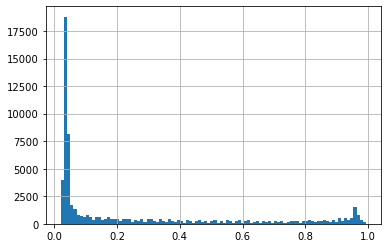

In [20]:
submission = pd.concat([pd.read_csv(path) for path in glob('node_submissions/*.csv')]).groupby('id').mean()
submission['toxic'].hist(bins=100)

In [21]:
#ensemble = pd.read_csv('../input/multitpu-inference/submission-ensemble.csv', index_col='id')
#ensemble['toxic'].hist(bins=100)

In [22]:
def scale_min_max_submission(submission):
    min_, max_ = submission['toxic'].min(), submission['toxic'].max()
    submission['toxic'] = (submission['toxic'] - min_) / (max_ - min_)
    return submission

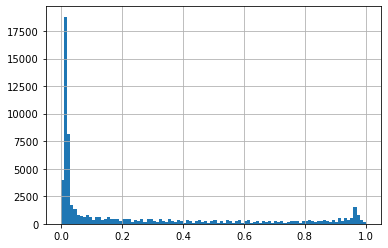

In [23]:
submission['toxic'] = (scale_min_max_submission(submission)['toxic'])
submission['toxic'].hist(bins=100)

In [24]:
submission.to_csv('submission.csv')